In [1]:
%reset
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

%matplotlib inline

import cmocean

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter



Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [ ]:
#da   = xr.open_dataset('/glade/derecho/scratch/eyankovsky/C-Star/setup_tools/setup_s2r_phys+bgc/1.Make_grid/frc_bgc.nc')
#da12p5 = xr.open_dataset('/glade/derecho/scratch/bachman/C-Star/setup_tools/EPAC12.5km/1.Make_grid/epac12p5km_frc_bgc.nc')
da = xr.open_dataset('/glade/derecho/scratch/bachman/ROMS_tools/EASTPAC_FROM_CESM/12p5/1.Make_grid/epac12p5km_frc_bgc.nc')
grd = xr.open_dataset('/glade/derecho/scratch/bachman/ROMS_tools/EASTPAC_FROM_CESM/12p5/1.Make_grid/epac12p5km_grd.nc')

#grd = xr.open_dataset('/glade/derecho/scratch/eyankovsky/C-Star/setup_tools/EASTPAC/EASTPAC_25KM/1.Make_grid/epac25km_grd.nc')


#parent_grd = xr.open_dataset('/glade/derecho/scratch/eyankovsky/C-Star/setup_tools/EASTPAC/EASTPAC_25KM/1.Make_grid/pacmed_0p25_grd_corrected.nc')


In [ ]:
da.iron_time-730
#1 year forcing we'd keep the file as is
#Jan index 0
#April 3
#July 6
#Oct 9

In [ ]:
#da=da.drop_vars(['pco2_time','pco2_air','dust_time','dust'])
#da = da.rename({'iron_time':'ALK_time'})
#da = da.rename({'iron':'ALK'})

#da.ALK_time.attrs["long_name"] = "time since 1995-01-01"

da['ALK'] = da.iron*0 #= da.ALK*0+1.
da['ALK_time'] = da.iron_time#+365+365
should 
da['pco2_time'] = da.ALK_time
da['iron_time'] = da.ALK_time
da['dust_time'] = da.ALK_time

print(da)

In [5]:
#Box model: 10 mol/m2/yr same as Mengyang
10/ 365.0 / 86400.0 * 1.0e3
#3.17e-4 #mmol/m2/s

#Mengyang 10mol/m2/year
#"10000/(365*86400)

0.00031709791983764585

In [35]:
true_lat = 37.78
true_lon = -122.43+360

lat_array = grd['lat_rho'].copy()
lon_array = grd['lon_rho'].copy()
# lon_array.data = np.where(lon_array.data < -200, lon_array.data+360., lon_array.data)


# Find nearest point to each site on MOM grid

abslat = np.abs(lat_array-true_lat)
abslon = np.abs(lon_array-true_lon)
c = np.maximum(abslat,abslon)

([yloc],[xloc]) = np.where(c == np.min(c))

print(xloc,yloc)
lon_test = lon_array.isel(eta_rho=yloc, xi_rho=xloc)
lat_test = lat_array.isel(eta_rho=yloc, xi_rho=xloc)

print(lon_test.values,lat_test.values)
print(true_lon,true_lat)

179 206
237.62385139842155 37.75118367768856
237.57 37.78


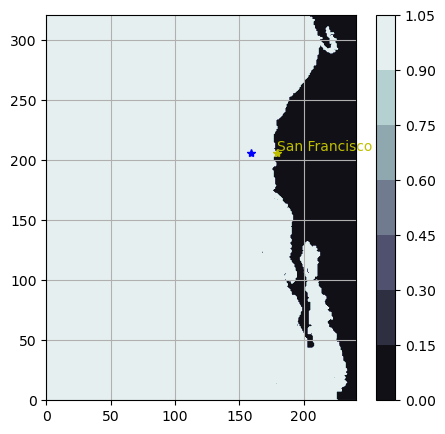

In [36]:
depth = np.ma.array(grd.mask_rho)#, mask=grd.hraw >0)
resfac=2

fig = plt.figure(figsize=(5,5),dpi=100)
plt.contourf(depth,cmap='bone')
plt.plot(xloc,yloc,'*',color='y')
plt.plot(xloc-10*resfac,yloc,'*',color='b')

plt.text(xloc,yloc+2,'San Francisco',color='y')
plt.grid()
plt.colorbar()

# print(grd.lon_rho[104,90]-360)
# print(grd.lat_rho[104,90])

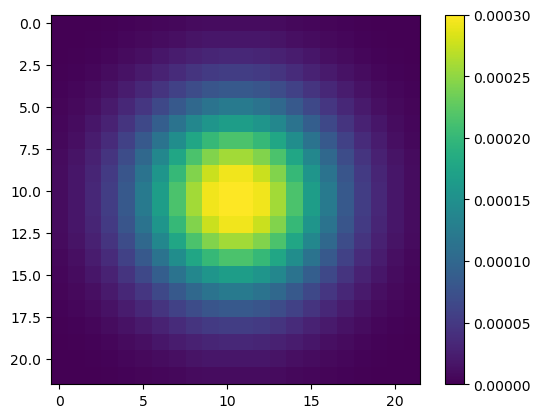

0.0003120853705307145

In [37]:
N = 11*resfac  # kernel size
k1d = signal.gaussian(N, std=2*resfac).reshape(N, 1)
kernel = np.outer(k1d, k1d)*3.17e-4
plt.imshow(kernel,vmin=0,vmax=3e-4)
plt.colorbar()

plt.show()
np.nanmax(kernel)
# A = np.zeros((16, 16))
# A[5, 9] = 1    # random
# plt.imshow(A)
# plt.show()

# row, col = np.where(A == 1)
# A[row[0]-(N//2):row[0]+(N//2)+1, col[0]-(N//2):col[0]+(N//2)+1] = kernel
# plt.imshow(A)

(0.0, 0.00032)

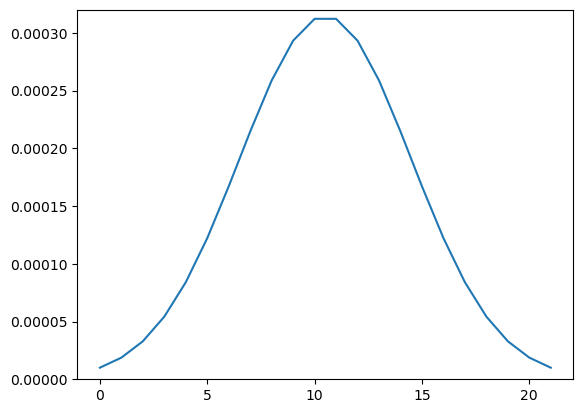

In [38]:
plt.plot(kernel[5*resfac,:])
plt.ylim([0,3.2e-4])


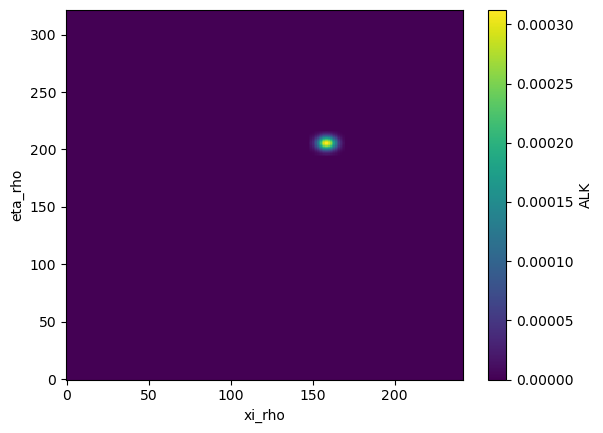

In [39]:
alk_flux = da.ALK[:]

low_lat = yloc-int(np.floor(N/2))
hi_lat  = yloc-int(np.floor(N/2))+N
low_lon = xloc-int(np.floor(N/2))-10*resfac
hi_lon  = xloc-int(np.floor(N/2))-10*resfac + N
alk_flux[:,low_lat:hi_lat,low_lon:hi_lon]=kernel


alk_flux[0,:].plot()

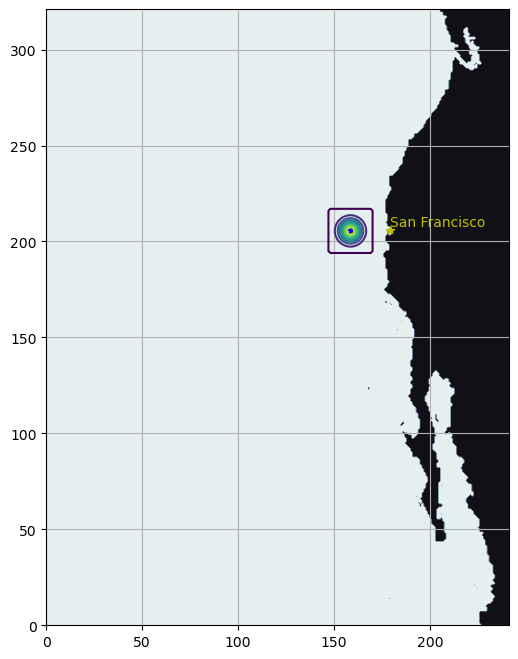

In [40]:
depth = np.ma.array(grd.mask_rho)#, mask=grd.hraw >0)
fig = plt.figure(figsize=(8,8),dpi=100)

plt.contourf(depth,cmap='bone')
#plt.colorbar()

plt.plot(xloc,yloc,'*',color='y')
plt.plot(xloc-10*resfac,yloc,'*',color='b')
plt.contour(alk_flux[0,:])
plt.gca().set_aspect('equal')

plt.text(xloc,yloc+2,'San Francisco',color='y')
plt.grid()



In [41]:
alk_flux.shape
da['ALK'] = alk_flux;
da.ALK.attrs["long_name"]="ALK flux into ocean"
da.ALK.attrs["units"]="mmol/m2/s"


In [42]:
da

<xarray.Dataset>
Dimensions:    (eta_rho: 322, time: 168, xi_rho: 242)
Dimensions without coordinates: eta_rho, time, xi_rho
Data variables:
    pco2_time  (time) float64 1.095e+03 1.126e+03 ... 6.148e+03 6.178e+03
    pco2_air   (time, eta_rho, xi_rho) float32 ...
    iron_time  (time) float64 1.095e+03 1.126e+03 ... 6.148e+03 6.178e+03
    iron       (time, eta_rho, xi_rho) float32 2.688e-08 2.715e-08 ... 1.077e-07
    dust_time  (time) float64 1.095e+03 1.126e+03 ... 6.148e+03 6.178e+03
    dust       (time, eta_rho, xi_rho) float32 ...
    ALK        (time, eta_rho, xi_rho) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ALK_time   (time) float64 1.095e+03 1.126e+03 ... 6.148e+03 6.178e+03
Attributes:
    Title:     ROMS srf bgc forcings field
    Date:      30-Oct-2024
    gridfile:  /glade/derecho/scratch/bachman/ROMS_tools/EASTPAC_FROM_CESM/12...

In [44]:
%rm ALK_forcing_12p5.nc
da.to_netcdf('ALK_forcing_12p5.nc')


In [46]:
test = xr.open_dataset('ALK_forcing_12p5.nc')
test.dust_time

<xarray.DataArray 'dust_time' (time: 168)>
array([1095.25  , 1125.6875, 1156.125 , 1186.5625, 1217.    , 1247.4375,
       1277.875 , 1308.3125, 1338.75  , 1369.1875, 1399.625 , 1430.0625,
       1460.5   , 1490.9375, 1521.375 , 1551.8125, 1582.25  , 1612.6875,
       1643.125 , 1673.5625, 1704.    , 1734.4375, 1764.875 , 1795.3125,
       1825.75  , 1856.1875, 1886.625 , 1917.0625, 1947.5   , 1977.9375,
       2008.375 , 2038.8125, 2069.25  , 2099.6875, 2130.125 , 2160.5625,
       2191.    , 2221.4375, 2251.875 , 2282.3125, 2312.75  , 2343.1875,
       2373.625 , 2404.0625, 2434.5   , 2464.9375, 2495.375 , 2525.8125,
       2556.25  , 2586.6875, 2617.125 , 2647.5625, 2678.    , 2708.4375,
       2738.875 , 2769.3125, 2799.75  , 2830.1875, 2860.625 , 2891.0625,
       2921.5   , 2951.9375, 2982.375 , 3012.8125, 3043.25  , 3073.6875,
       3104.125 , 3134.5625, 3165.    , 3195.4375, 3225.875 , 3256.3125,
       3286.75  , 3317.1875, 3347.625 , 3378.0625, 3408.5   , 3438.9375,
       3469.375 , 3499.8125, 3530.25  , 3560.6875, 3591.125 , 3621.5625,
       3652.    , 3682.4375, 3712.875 , 3743.3125, 3773.75  , 3804.1875,
       3834.625 , 3865.0625, 3895.5   , 3925.9375, 3956.375 , 3986.8125,
       4017.25  , 4047.6875, 4078.125 , 4108.5625, 4139.    , 4169.4375,
       4199.875 , 4230.3125, 4260.75  , 4291.1875, 4321.625 , 4352.0625,
       4382.5   , 4412.9375, 4443.375 , 4473.8125, 4504.25  , 4534.6875,
       4565.125 , 4595.5625, 4626.    , 4656.4375, 4686.875 , 4717.3125,
       4747.75  , 4778.1875, 4808.625 , 4839.0625, 4869.5   , 4899.9375,
       4930.375 , 4960.8125, 4991.25  , 5021.6875, 5052.125 , 5082.5625,
       5113.    , 5143.4375, 5173.875 , 5204.3125, 5234.75  , 5265.1875,
       5295.625 , 5326.0625, 5356.5   , 5386.9375, 5417.375 , 5447.8125,
       5478.25  , 5508.6875, 5539.125 , 5569.5625, 5600.    , 5630.4375,
       5660.875 , 5691.3125, 5721.75  , 5752.1875, 5782.625 , 5813.0625,
       5843.5   , 5873.9375, 5904.375 , 5934.8125, 5965.25  , 5995.6875,
       6026.125 , 6056.5625, 6087.    , 6117.4375, 6147.875 , 6178.3125])
Dimensions without coordinates: time

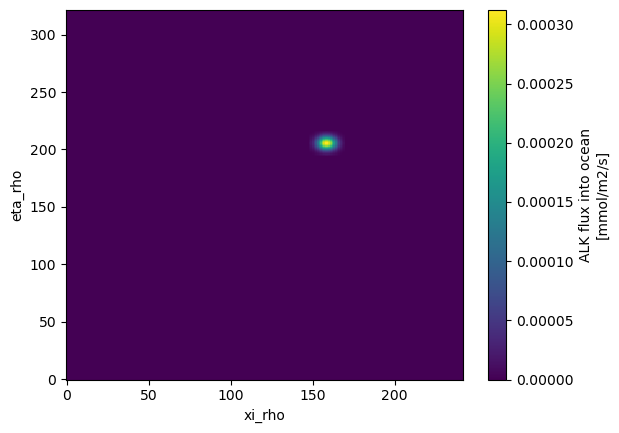

In [47]:
#test.ALK[0,low_lat+5,low_lon:hi_lon].plot()
test.ALK[0,:].plot()

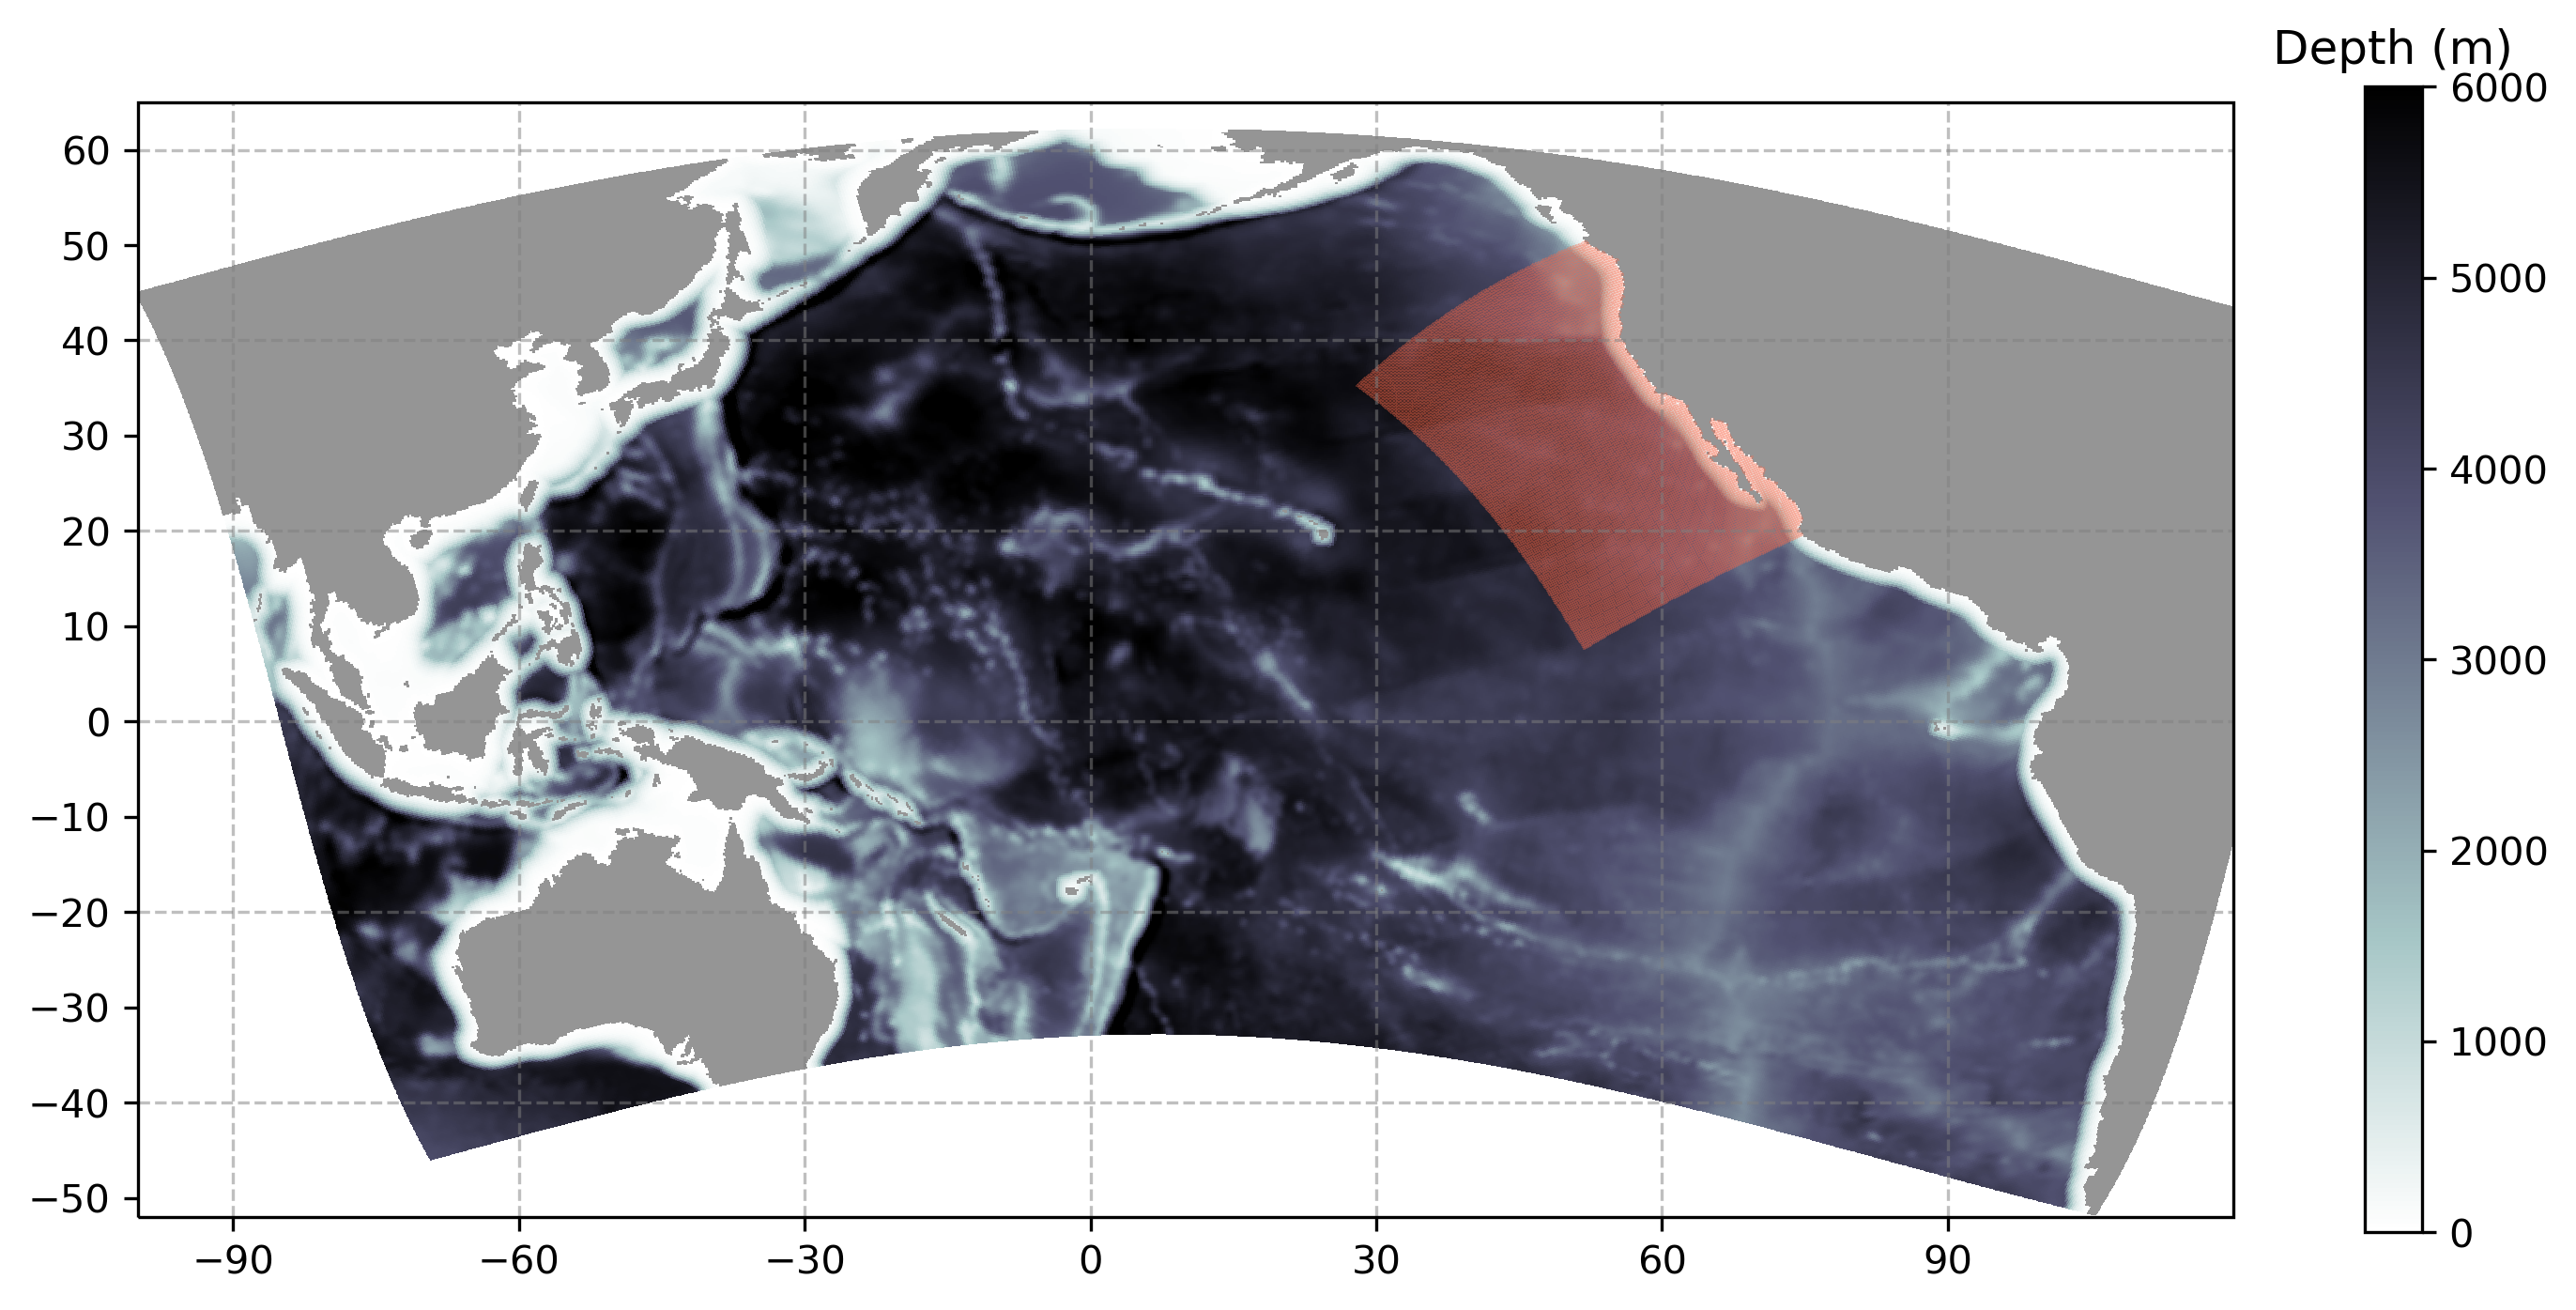

In [97]:

fig = plt.figure(figsize=(12,12),dpi=300)

ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

sca = ax.pcolormesh(parent_grd.lon_rho-180,
                parent_grd.lat_rho,
                parent_grd.h,
                transform=ccrs.PlateCarree(),
                cmap='bone_r',vmin=0,vmax=6000);
cb = fig.colorbar(sca, ax=ax, shrink=0.44)

sca = ax.pcolormesh(parent_grd.lon_rho-180,
                parent_grd.lat_rho,
                parent_grd.mask_rho.where(parent_grd.mask_rho<1),
                transform=ccrs.PlateCarree(),
                cmap='Greys',vmin=-1,vmax=1);

sca = ax.pcolormesh(grd.lon_rho-180,
                grd.lat_rho,
                grd.mask_rho.where(grd.mask_rho>0),
                transform=ccrs.PlateCarree(),
                cmap='Reds',alpha=0.3,vmin=-1,vmax=3);

cb.ax.set_title('Depth (m)')


ax.set_extent([-100, 120, -52, 65], ccrs.PlateCarree())
ax.set_xticks(np.arange(-90, 120, 30), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-50, 70, 10), crs=ccrs.PlateCarree())
# lon_formatter = LongitudeFormatter(zero_direction_label=False)
# lat_formatter = LatitudeFormatter()
# ax.xaxis.set_major_formatter(lon_formatter)
# ax.yaxis.set_major_formatter(lat_formatter)  
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  color='gray', alpha=0.5, linestyle='--')
#ax.stock_img()
#ax.add_feature(cfeature.LAND, facecolor='lightgray')

#ax.set_title('excess_ALK at surface ' + str(da.time.values[tstep])[:10], loc='left')


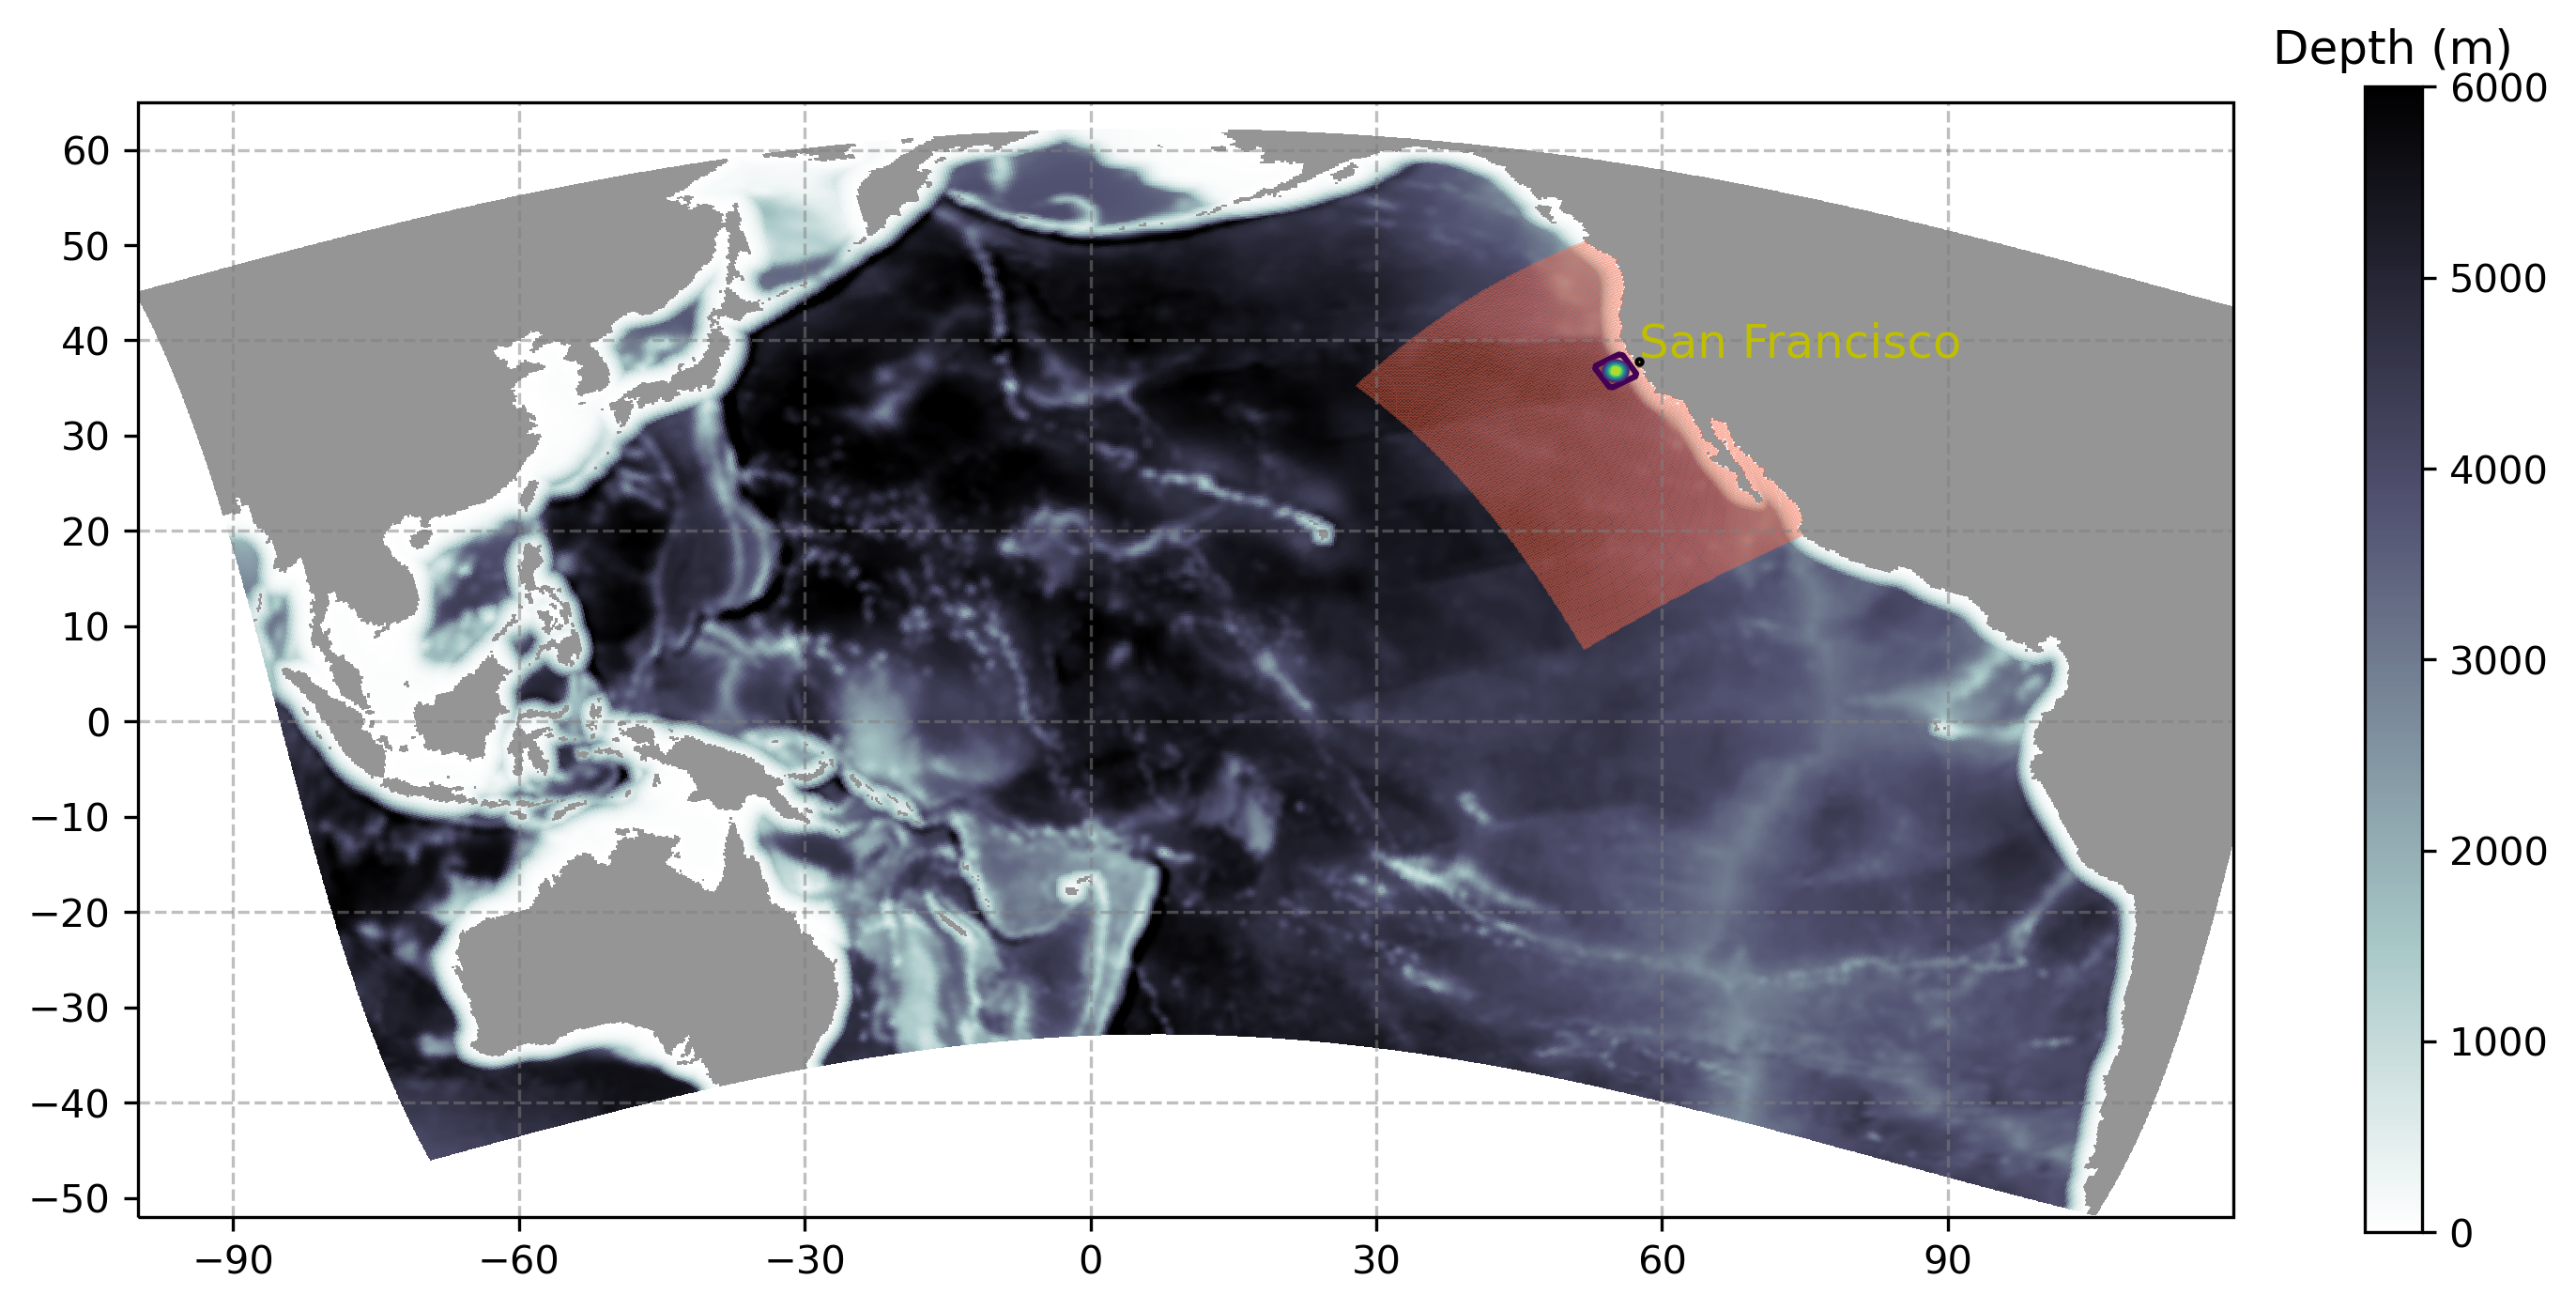

In [98]:
fig = plt.figure(figsize=(12,12),dpi=300)

ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

sca = ax.pcolormesh(parent_grd.lon_rho-180,
                parent_grd.lat_rho,
                parent_grd.h,
                transform=ccrs.PlateCarree(),
                cmap='bone_r',vmin=0,vmax=6000);
cb = fig.colorbar(sca, ax=ax, shrink=0.44)

sca = ax.pcolormesh(parent_grd.lon_rho-180,
                parent_grd.lat_rho,
                parent_grd.mask_rho.where(parent_grd.mask_rho<1),
                transform=ccrs.PlateCarree(),
                cmap='Greys',vmin=-1,vmax=1);

sca = ax.pcolormesh(grd.lon_rho-180,
                grd.lat_rho,
                grd.mask_rho.where(grd.mask_rho>0),
                transform=ccrs.PlateCarree(),
                cmap='Reds',alpha=0.3,vmin=-1,vmax=3);

plt.contour(grd.lon_rho-180,
            grd.lat_rho,
            alk_flux[0,:],
            transform=ccrs.PlateCarree());

cb.ax.set_title('Depth (m)')

plt.plot(true_lon-180,true_lat,'.',color='y',markeredgecolor='k',markersize=3,transform=ccrs.PlateCarree())
plt.text(true_lon-180,true_lat+.5,'San Francisco',fontsize=12,color='y',transform=ccrs.PlateCarree())

ax.set_extent([-100, 120, -52, 65], ccrs.PlateCarree())
ax.set_xticks(np.arange(-90, 120, 30), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-50, 70, 10), crs=ccrs.PlateCarree())
# lon_formatter = LongitudeFormatter(zero_direction_label=False)
# lat_formatter = LatitudeFormatter()
# ax.xaxis.set_major_formatter(lon_formatter)
# ax.yaxis.set_major_formatter(lat_formatter)  
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  color='gray', alpha=0.5, linestyle='--')
#ax.stock_img()
#ax.add_feature(cfeature.LAND, facecolor='lightgray')

#ax.set_title('excess_ALK at surface ' + str(da.time.values[tstep])[:10], loc='left')

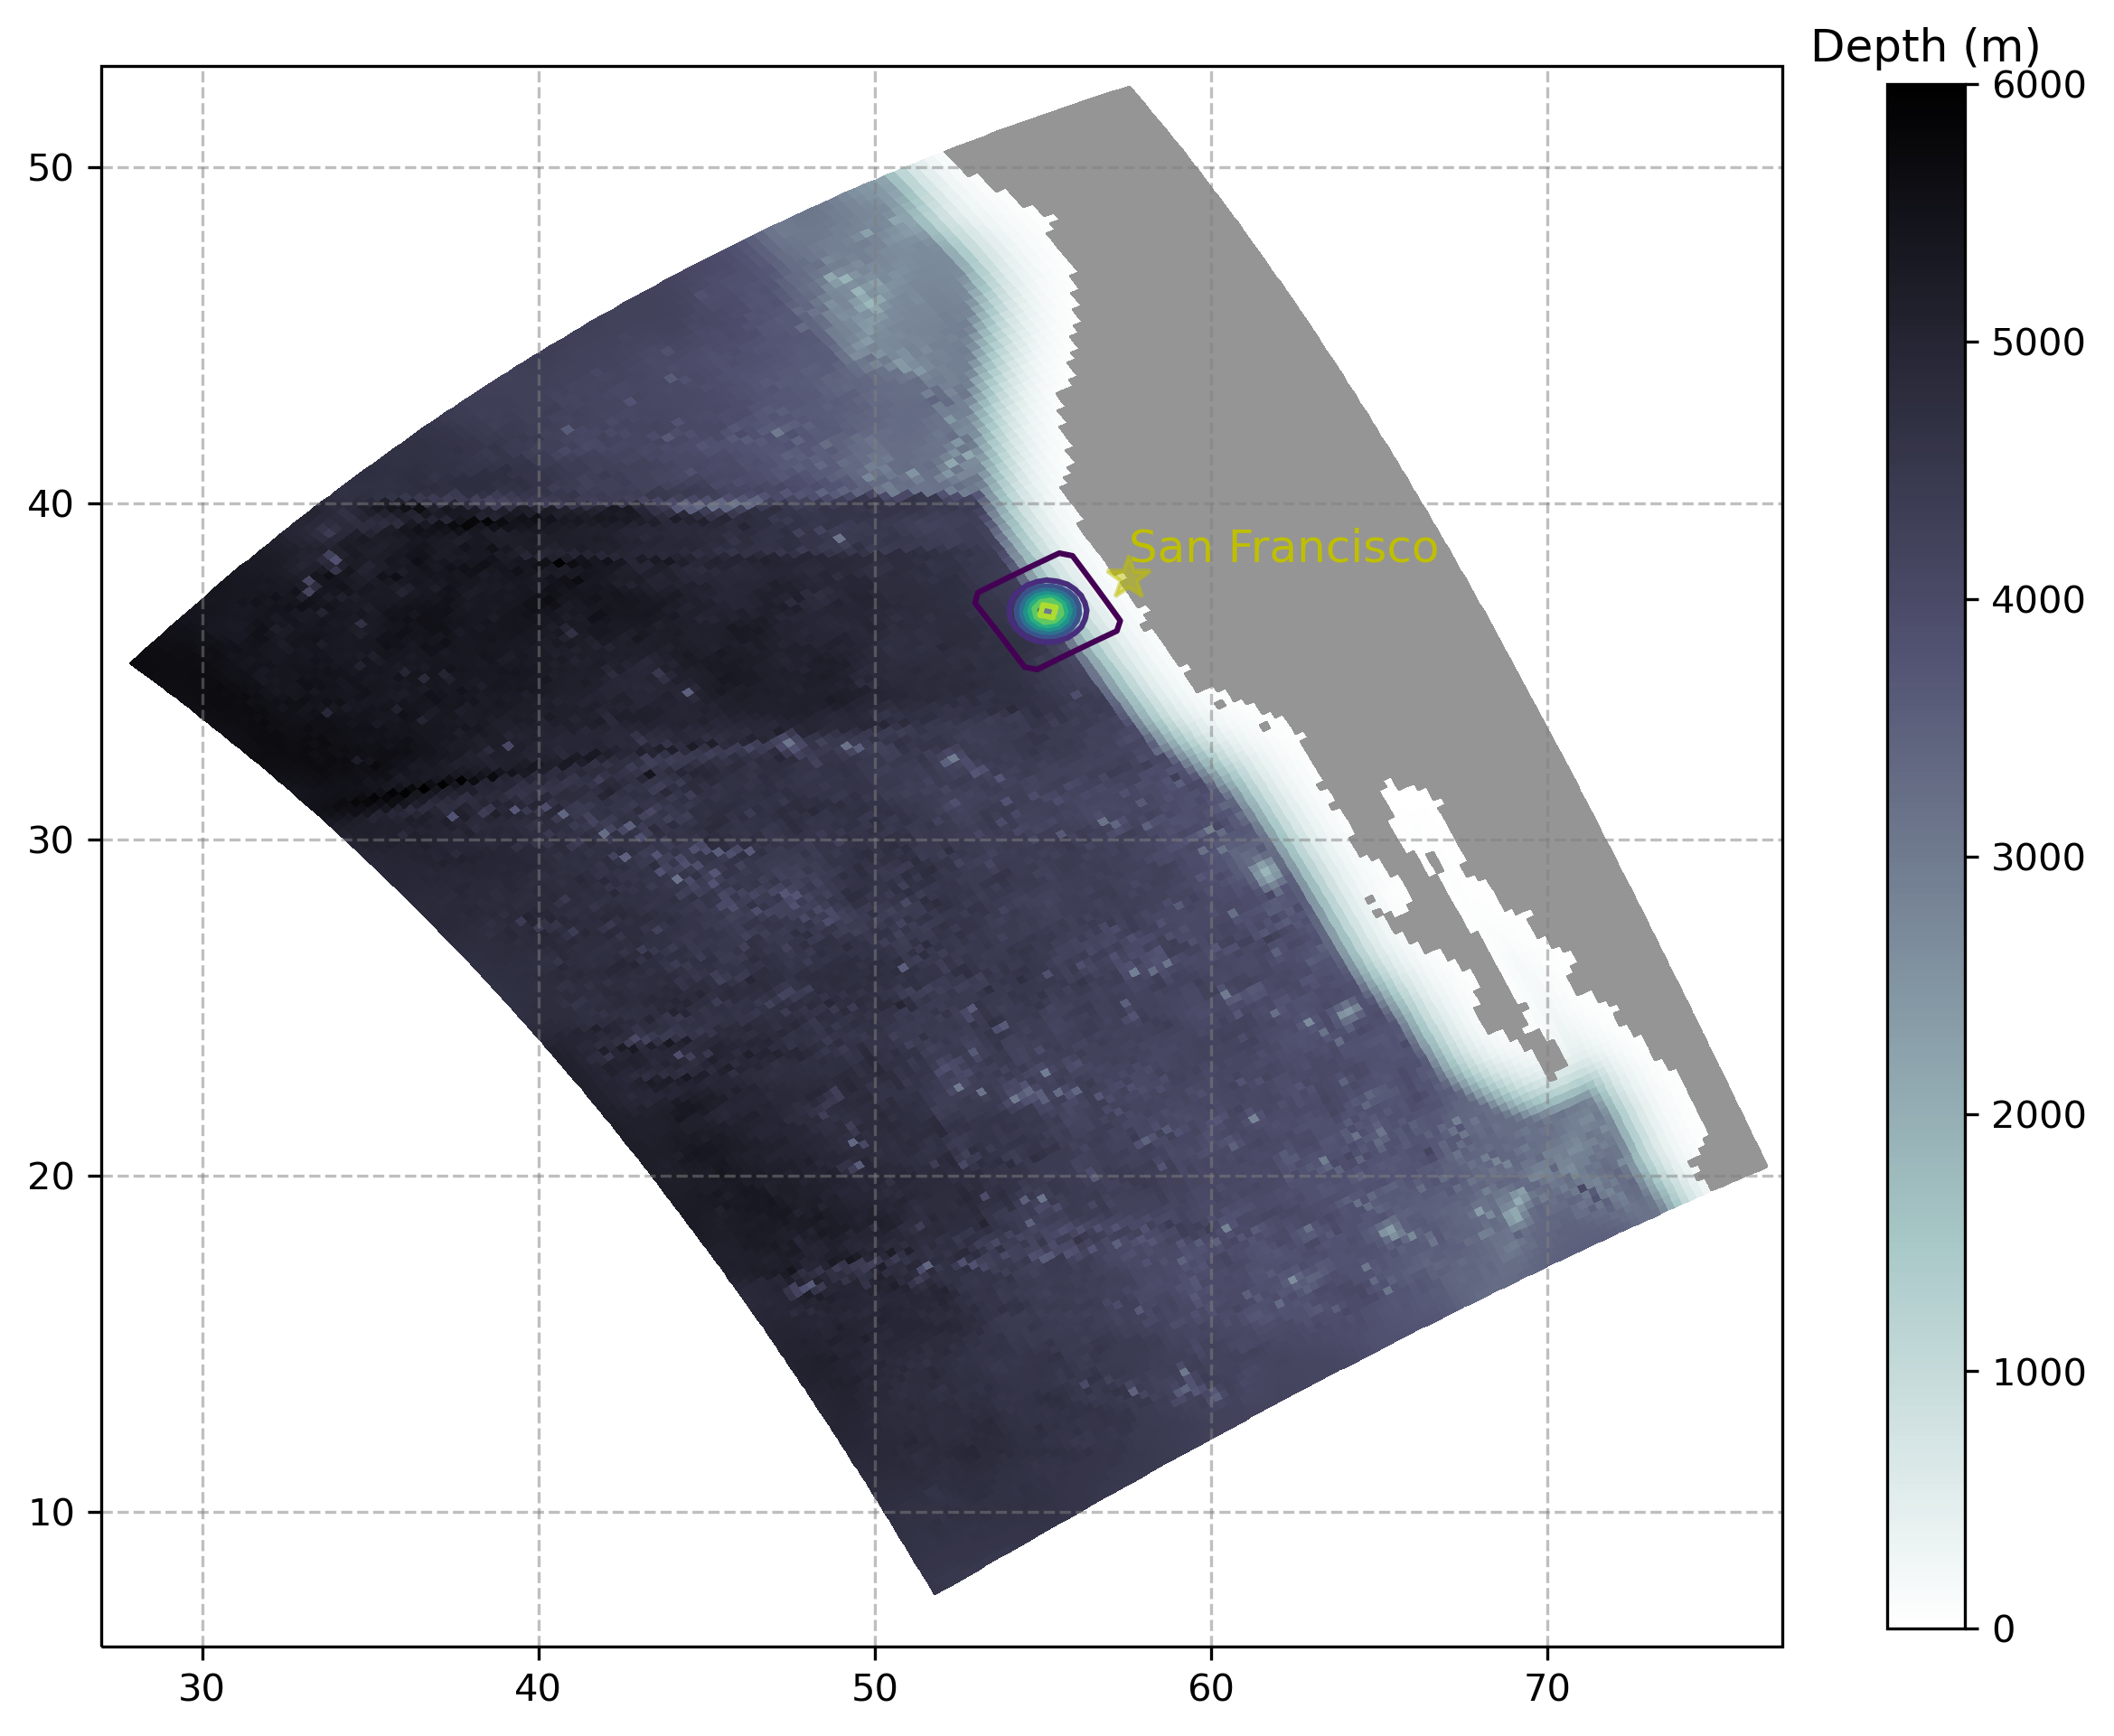

In [50]:
fig = plt.figure(figsize=(10,10),dpi=300)

ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

sca = ax.pcolormesh(grd.lon_rho-180,
                grd.lat_rho,
                grd.h,
                transform=ccrs.PlateCarree(),
                cmap='bone_r',vmin=0,vmax=6000);
cb = fig.colorbar(sca, ax=ax, shrink=0.74)

sca = ax.pcolormesh(grd.lon_rho-180,
                grd.lat_rho,
                grd.mask_rho.where(grd.mask_rho<1),
                transform=ccrs.PlateCarree(),
                cmap='Greys',vmin=-1,vmax=1);

plt.contour(grd.lon_rho-180,
            grd.lat_rho,
            alk_flux[0,:],
            transform=ccrs.PlateCarree());




cb.ax.set_title('Depth (m)')

plt.plot(true_lon-180,true_lat,'*',color='y',alpha=.5,markersize=12,transform=ccrs.PlateCarree())
plt.text(true_lon-180,true_lat+.5,'San Francisco',fontsize=12,color='y',transform=ccrs.PlateCarree())

# plt.plot(xloc-10*resfac,yloc,'*',color='b')
# plt.contour(alk_flux[0,:])

#plt.text(xloc,yloc+2,'San Francisco',color='y')

ax.set_extent([27, 77, 6, 53], ccrs.PlateCarree())
ax.set_xticks(np.arange(30, 80, 10), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(10, 60, 10), crs=ccrs.PlateCarree())
# lon_formatter = LongitudeFormatter(zero_direction_label=False)
# lat_formatter = LatitudeFormatter()
# ax.xaxis.set_major_formatter(lon_formatter)
# ax.yaxis.set_major_formatter(lat_formatter)  
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  color='gray', alpha=0.5, linestyle='--')
#ax.stock_img()
#ax.add_feature(cfeature.LAND, facecolor='lightgray')

#ax.set_title('excess_ALK at surface ' + str(da.time.values[tstep])[:10], loc='left')